Supporting Article: https://xyzjust.medium.com

Link to data: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

"timestamp" - timestamp field for grouping the data 
"cnt" - the count of a new bike shares 
"t1" - real temperature in C 
"t2" - temperature in C "feels like" 
"hum" - humidity in percentage 
"windspeed" - wind speed in km/h 
"weathercode" - category of the weather 
"isholiday" - boolean field - 1 holiday / 0 non holiday 
"isweekend" - boolean field - 1 if the day is weekend 
"season" - category field meteorological seasons:
    0-spring
    1-summer
    2-fall
    3-winter

"weathe_code" category description: 
    1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
    2 = scattered clouds / few clouds
    3 = Broken clouds
    4 = Cloudy
    7 = Rain/ light Rain shower/ Light rain 
    10 = rain with thunderstorm 
    26 = snowfall 
    94 = Freezing Fog

## 1. Import Functions

In [2]:
import sys
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### 1.1 Useful functions/dictionaries

In [5]:
season_dict = {
    0:'spring',
    1:'summer',
    2:'fall',
    3:'winter'}

In [6]:
weather_dict = {
    1:'Clear',
    2:'Few clouds',
    3:'Broken clouds',
    4:'Cloudy',
    7:'Light Rain shower',
    10:'Thunderstorm ',
    26:'Snowfall ',
    94:'Freezing Fog'
}

In [7]:
def myround(x, base=5):
    """
    Input a number and the target, will round to the nearest value.
    
    INPUT:
    x - a number
    base - default = 5, any base
    
    OUTPUT
    rounding to the nearest base
    
    """
    return base * round(float(x) / base)

In [8]:
def is_weekend(num):
    """
    Input 1 or 0, output "Weekend" or "Weekday"
    """
    if num == 1:
        return 'Weekend'
    else:
        return 'Weekday'

## 2. Import Data

In [9]:
file_name = 'london_merged.csv'

In [10]:
df = pd.read_csv('./{file_name}'.format(file_name=file_name))

In [11]:
df['cnt'].mean()

1143.1016423567244

In [12]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


## 3. Data Cleaning / Exploring

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'] )  # change to the correct timeseries

In [14]:
"""Where there are missing hours"""
df['timestamp_shift'] = df['timestamp'].shift(1)
df['time_difference'] = df['timestamp'] - df['timestamp_shift']
df['timestamp_date'] = [d.date() for d in df['timestamp']]
df['timestamp_date_shift'] = df['timestamp_date'].shift(1)

# df_gaps_in_data = df.sort_values(by='time_difference', ascending = False ).head(31)

df_gaps_in_data = df[df['time_difference'] != dt.timedelta(hours = 1)]
list_ignore_dates = set([d for d in df_gaps_in_data['timestamp_date_shift'] if pd.isnull(d) != True] + \
                        [d for d in df_gaps_in_data['timestamp_date']])

In [15]:
"""Daily Cycle"""
cycles_in_days_ = df.groupby('timestamp_date')[['cnt']].sum().reset_index()
cycles_in_days = cycles_in_days_[~cycles_in_days_['timestamp_date'].isin(list_ignore_dates)].describe()
cycles_in_days.columns = ['cycles per day']
cycles_in_days['cycles per day'] = [int(d) for d in cycles_in_days['cycles per day']]

In [16]:
cycles_in_days.T

,count,mean,std,min,25%,50%,75%,max
cycles per day,690,27408,8463,4869,22197,27186,33609,72504


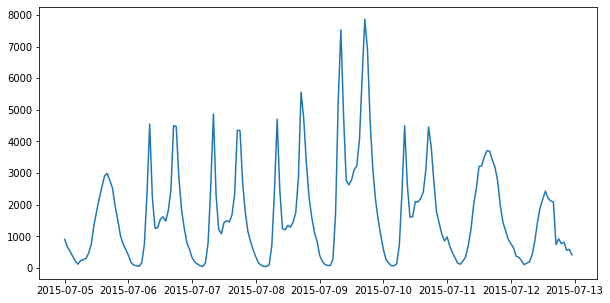

In [17]:
df_plot = df[(df['timestamp_date'] >= pd.to_datetime('2015-07-05')) & (df['timestamp_date'] <= pd.to_datetime('2015-07-12'))]
plt.figure(figsize=(10,5))
plt.plot(df_plot['timestamp'], df_plot['cnt'])

plt.show()

In [18]:
cycles_in_days_['cnt (k)'] = cycles_in_days_['cnt']/1000
cycles_in_days_['cnt_K_rolling_7D'] = cycles_in_days_['cnt (k)'].rolling(window=7).mean()
cycles_in_days_['cnt_K_rolling_14D'] = cycles_in_days_['cnt (k)'].rolling(window=14).mean()
cycles_in_days_['cnt_K_rolling_30D'] = cycles_in_days_['cnt (k)'].rolling(window=30).mean()

In [19]:
"""2 Anomalies Spotted"""
cycles_in_days_.sort_values(by = 'cnt (k)', ascending = False)[:5] 

,timestamp_date,cnt,cnt (k),cnt_K_rolling_7D,cnt_K_rolling_14D,cnt_K_rolling_30D
186,2015-07-09,72504,72.504,42.620714,40.068714,37.107900
214,2015-08-06,63468,63.468,42.610143,35.730143,37.241400
562,2016-07-19,46021,46.021,39.649857,37.239429,33.903400
573,2016-07-30,45608,45.608,38.099286,39.791286,37.361633
490,2016-05-08,44758,44.758,36.346000,31.592643,28.361200


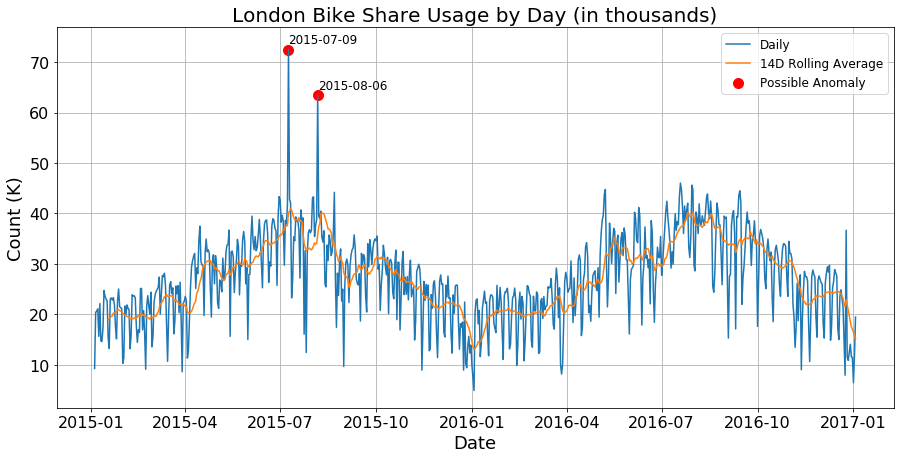

In [20]:
fig, ax = plt.subplots(figsize=(15,7))

df_plot = cycles_in_days_

points = cycles_in_days_.sort_values(by = 'cnt (k)', ascending = False)[:2]

ax.plot(df_plot['timestamp_date'], df_plot['cnt (k)'], label = 'Daily')
ax.plot(df_plot['timestamp_date'], df_plot['cnt_K_rolling_14D'], label = '14D Rolling Average')

ax.scatter(points['timestamp_date'], points['cnt (k)'], s = 100,  c = 'r', label ='Possible Anomaly')

for i in np.arange(len(points)):
#     if points['cnt'].iloc[i]  != 46021:
    ax.annotate(points['timestamp_date'].iloc[i], 
                (points['timestamp_date'].iloc[i], points['cnt (k)'].iloc[i] + 1.2),
               size = 12)
#     else:
#         ax.annotate(points['timestamp_date'].iloc[i], 
#                     (points['timestamp_date'].iloc[i], points['cnt (k)'].iloc[i] + 3) ,
#                    size = 12)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (K)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage by Day (in thousands)', fontsize=20)

plt.grid()
plt.legend(fontsize=12)
plt.show()


In [21]:
df['season_name'] = df['season'].apply(lambda x: season_dict[x])

In [22]:
df['weather_name'] = df['weather_code'].apply(lambda x: weather_dict[x])

In [23]:
season_weather_df_ = df[df['weather_code'] < 10].groupby(['season_name','weather_code'])[['cnt']].mean().unstack('weather_code')

In [24]:
season_weather_df_.columns  = [d[1] for d in season_weather_df_.columns]

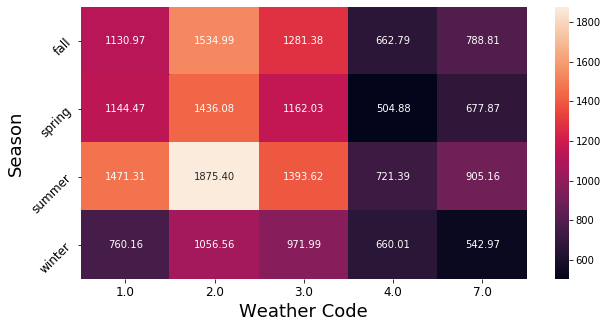

In [25]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(season_weather_df_, annot=True, fmt=".2f", ax=ax)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=45 )


plt.xlabel('Weather Code', fontsize=18)
plt.ylabel('Season', fontsize=18)

plt.show()

some correlation, can't see a very strong link

In [26]:
df_box_weather = pd.DataFrame([])
for code in df.sort_values(by ='weather_code')['weather_code'].unique():
    df_split = df[df['weather_code'] == code]['cnt'].reset_index()
    del df_split['index']
    df_split.columns = [weather_dict[code]]
    df_box_weather = df_box_weather.merge(df_split, left_index=True, right_index=True, how='outer')

In [27]:
df_box_season = pd.DataFrame([])
for code in df.sort_values(by ='season')['season'].unique():
    df_split = df[df['season'] == code]['cnt'].reset_index()
    del df_split['index']
    df_split.columns = [season_dict[code]]
    df_box_season = df_box_season.merge(df_split, left_index=True, right_index=True, how='outer')

In [28]:
df['nearest_5_degrees'] = df['t1'].apply(lambda x: myround(x,2))
df_box_tempearture = pd.DataFrame([])
for code in df.sort_values(by ='t1')['nearest_5_degrees'].unique():
    df_split = df[df['nearest_5_degrees'] == code]['cnt'].reset_index()
    del df_split['index']
    df_split.columns = [round(code,2)]
    df_box_tempearture = df_box_tempearture.merge(df_split, left_index=True, right_index=True, how='outer')

In [173]:
"""Uncomment for plot"""
# plt.figure(figsize=(17,5))
# df_box_tempearture.boxplot(rot=45, fontsize=15, showfliers=False)
# plt.show()

'Uncomment for plot'

In [174]:
"""Uncomment for plot"""
# plt.figure(figsize=(10,5))
# df_box_weather.boxplot(rot=50, fontsize=15, showfliers=False)
# plt.show()

'Uncomment for plot'

In [175]:
"""Uncomment for plot"""
# plt.figure(figsize=(10,5))
# df_box_season.boxplot(rot=50, fontsize=15, showfliers=False)
# plt.show()

'Uncomment for plot'

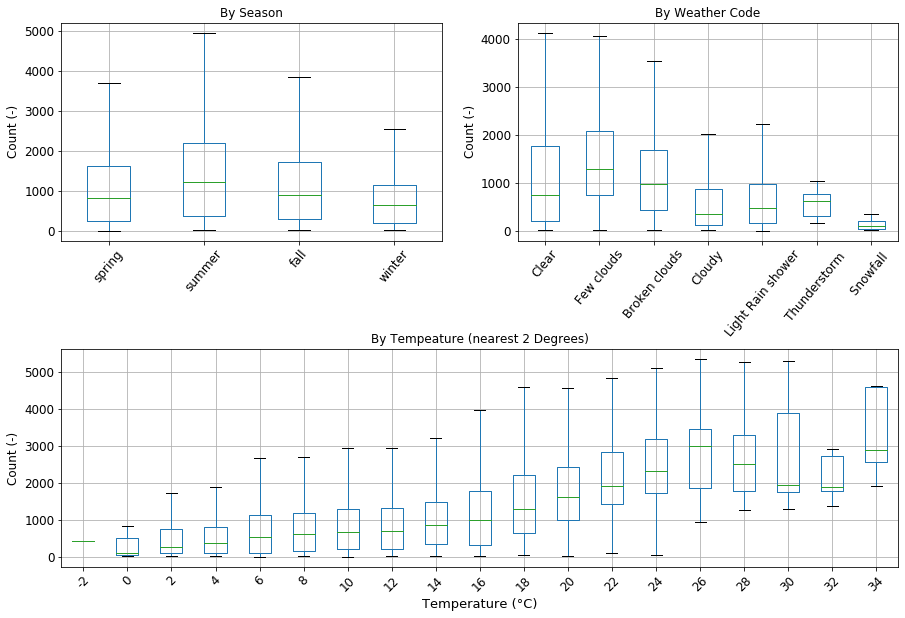

In [35]:
plt.figure(figsize=(15,10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)


df_box_season.boxplot(rot=50, fontsize=12, showfliers=False, ax =ax1)
df_box_weather.boxplot(rot=50, fontsize=12, showfliers=False, ax =ax2)
df_box_tempearture.boxplot(rot=45, fontsize=12, showfliers=False, ax=ax3)

ax1.title.set_text('By Season')
ax2.title.set_text('By Weather Code')
ax3.title.set_text('By Tempeature (nearest 2 Degrees)')

ax1.set_ylabel('Count (-)', fontsize = 12)
ax2.set_ylabel('Count (-)', fontsize = 12)
ax3.set_ylabel('Count (-)', fontsize = 12)

ax3.set_xlabel("Temperature (\xb0C)", fontsize = 13)
plt.subplots_adjust(hspace=0.5)

plt.show()

In [36]:
print("uncomment to show outliers, very messy")
# plt.figure(figsize=(15,10))

# ax1 = plt.subplot(221)
# ax2 = plt.subplot(222)
# ax3 = plt.subplot(212)


# df_box_season.boxplot(rot=50, fontsize=12, showfliers=True, ax =ax1)
# df_box_weather.boxplot(rot=50, fontsize=12, showfliers=True, ax =ax2)
# df_box_tempearture.boxplot(rot=45, fontsize=12, showfliers=True, ax=ax3)

# ax1.title.set_text('By Season')
# ax2.title.set_text('By Weather Code')
# ax3.title.set_text('By Tempeature (nearest 2 Degrees)')

# ax1.set_ylabel('Count (-)', fontsize = 12)
# ax2.set_ylabel('Count (-)', fontsize = 12)
# ax3.set_ylabel('Count (-)', fontsize = 12)

# plt.subplots_adjust(hspace=0.5)

# plt.show()

uncomment to show outliers, very messy


In [37]:
cycles_in_days_['day_of_week'] = [d.isoweekday() for d in cycles_in_days_['timestamp_date']]

In [38]:
cycles_in_days_['is_weekend'] = cycles_in_days_['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)

In [39]:
df['day_of_week'] = [d.isoweekday() for d in df['timestamp_date']]

In [40]:
df_box_weekday = pd.DataFrame([])
for code in df.sort_values(by ='day_of_week')['day_of_week'].unique():
    df_split = df[df['day_of_week'] == code]['cnt'].reset_index()
    del df_split['index']
    df_split.columns = [round(code,2)]
    df_box_weekday = df_box_weekday.merge(df_split, left_index=True, right_index=True, how='outer')

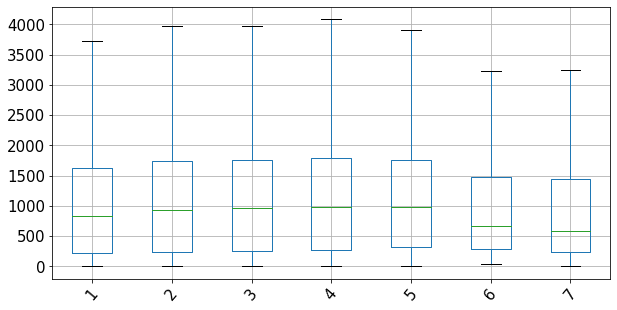

In [41]:
plt.figure(figsize=(10,5))
df_box_weekday.boxplot(rot=50, fontsize=15, showfliers=False)
plt.show()

#### Introduce seasons

In [42]:
change_season = df.groupby(['timestamp_date'])[['season']].agg(lambda x: pd.Series.mode(x) )
change_season['season_s'] = change_season['season'].shift(1).fillna(10)
change_season['change_season'] = 1*(change_season['season_s'] != change_season['season'])
change_season['change_season'] = change_season['change_season'].cumsum()
change_season = change_season.reset_index().groupby(['change_season','season'])[['timestamp_date']].agg(['min','max'])
change_season.columns = [d[1] for d in change_season.columns]
change_season['middle'] = change_season.apply(lambda x: x['min'] + (x['max'] - x['min'])/2 , axis = 1)

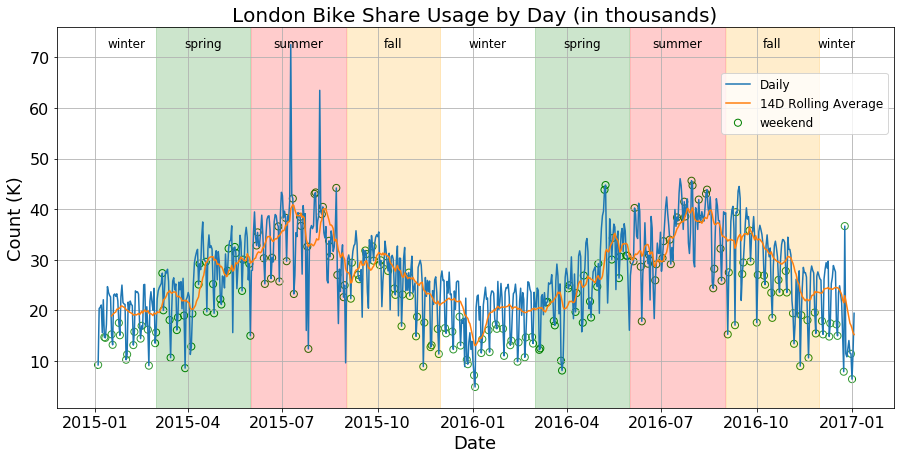

In [43]:
fig, ax = plt.subplots(figsize=(15,7))

df_plot = cycles_in_days_

points = cycles_in_days_.sort_values(by = 'cnt (k)', ascending = False)[:2]

ax.plot(df_plot['timestamp_date'], df_plot['cnt (k)'], label = 'Daily')
ax.scatter(df_plot[df_plot['is_weekend'] == 1]['timestamp_date'],
           df_plot[df_plot['is_weekend'] == 1]['cnt (k)'],
           label = 'weekend',
           facecolors='none',
           edgecolors='g',
           s=50)
ax.plot(df_plot['timestamp_date'], df_plot['cnt_K_rolling_14D'], label = '14D Rolling Average')
## add in change in season:
for i, v in change_season.reset_index().iterrows():
#     ax.axvspan(*mdates.datestr2num(['10/27/2015', '11/2/2015']), color='red', alpha=0.5)
    if v['season'] == 1:
        color = 'red'
    elif v['season'] == 0:
        color = 'green'
    elif v['season'] == 3:
        color = 'white'
    else:
        color = 'orange'

    ax.axvspan(*mdates.datestr2num([str(v['min']), str(v['max'])]), color=color, alpha=0.2)
    plt.text(v['middle'], 72, season_dict[v['season']], size=12, rotation=0, ha="center")

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (K)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage by Day (in thousands)', fontsize=20)

plt.grid()
plt.legend(fontsize=12, loc='right',bbox_to_anchor=(1,0.8))
plt.show()



#### Get hour of the day

In [44]:
df['hour_of_day'] = df['timestamp'].dt.hour

In [45]:
print("Unhide for everyday of the week")

# weekend_weekday = df.groupby(['hour_of_day','day_of_week'])[['cnt']].mean().unstack()
# weekend_weekday.columns = [d[1] for d in weekend_weekday.columns]

# for i in [1,2,3,4,5,6,7]:
#     plt.bar(weekend_weekday.index, weekend_weekday[i], alpha= 0.5, label =str(i))
#     plt.title(str(i))
#     plt.show()
# #     plt.bar(weekend_weekday.index, weekend_weekday['Weekend'], alpha= 0.5, label ='Weekend')

Unhide for everyday of the week


In [46]:
weekend_weekday = df.groupby(['hour_of_day','is_weekend'])[['cnt']].mean().unstack()
weekend_weekday.columns = [is_weekend(d[1]) for d in weekend_weekday.columns]

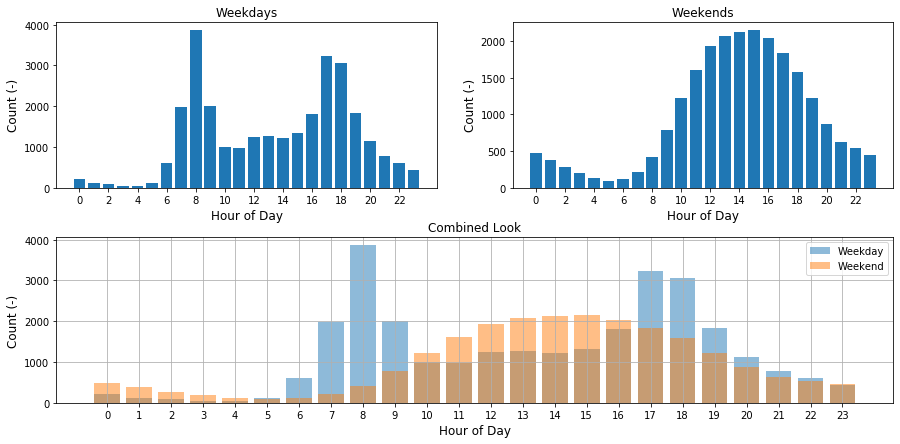

In [47]:
plt.figure(figsize=(15,7))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)


ax1.bar(weekend_weekday.index, weekend_weekday['Weekday'])
ax2.bar(weekend_weekday.index, weekend_weekday['Weekend'])

plt.bar(weekend_weekday.index, weekend_weekday['Weekday'], alpha= 0.5, label ='Weekday')
plt.bar(weekend_weekday.index, weekend_weekday['Weekend'], alpha= 0.5, label ='Weekend')

ax1.title.set_text('Weekdays')
ax2.title.set_text('Weekends')
ax3.title.set_text('Combined Look')

ax1.xaxis.set_ticks(np.arange(0,24, 2.0))
ax2.xaxis.set_ticks(np.arange(0,24, 2.0))
plt.xticks(np.arange(0,24, 1.0))

ax1.set_ylabel('Count (-)', fontsize = 12)
ax2.set_ylabel('Count (-)', fontsize = 12)
ax3.set_ylabel('Count (-)', fontsize = 12)

ax1.set_xlabel('Hour of Day', fontsize = 12)
ax2.set_xlabel('Hour of Day', fontsize = 12)
ax3.set_xlabel('Hour of Day', fontsize = 12)

plt.subplots_adjust(hspace=0.3)
plt.grid()
plt.legend()
plt.show()

### 3 Feature Selection/Addition

In [48]:
df_clean = df.copy()

In [49]:
categorical_columns = ['weather_code',
                       'is_holiday',
                       'is_weekend',
                       'season',
                       'hour_of_day']

In [50]:
continuous_columns = ['timestamp', 'cnt', 't1', 'hum', 'wind_speed']

In [51]:
df_continuous = df[continuous_columns]

In [52]:
for cate in categorical_columns:
    df_continuous = df_continuous.merge(pd.get_dummies(df_clean[cate], dummy_na = False, drop_first = True, prefix = cate), 
                                        left_index = True,
                                        right_index = True,
                                        how = 'outer')

In [53]:
y = df_continuous['cnt']

In [54]:
X = df_continuous.iloc[:, 2:]

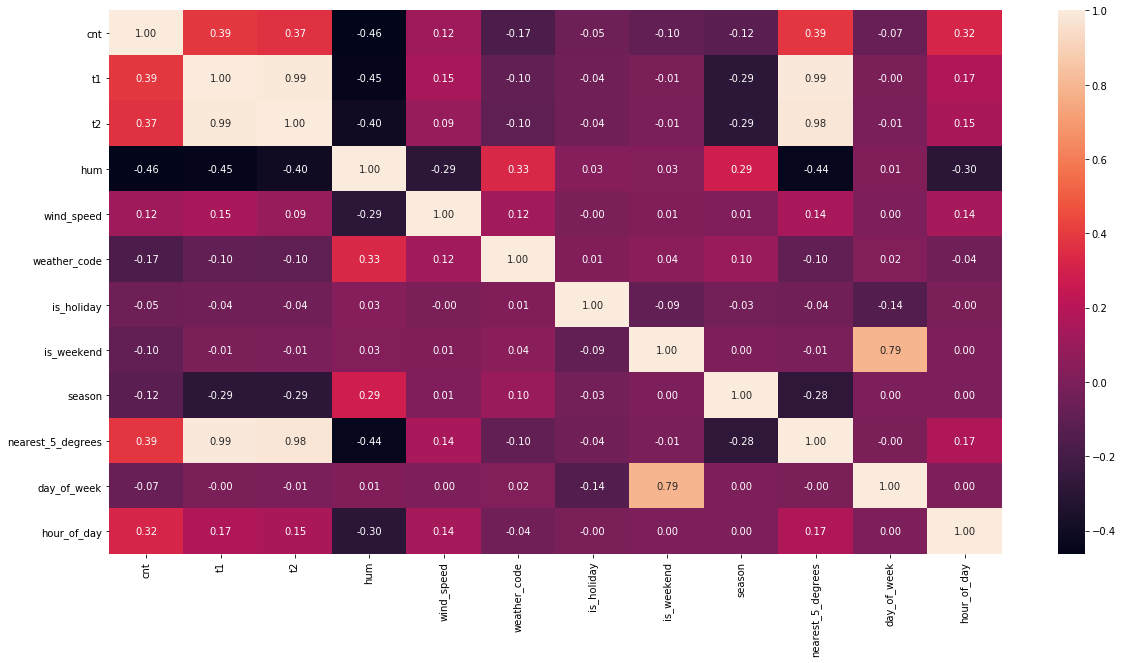

In [55]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax)

#### t1 and t2 are highly correlated, remove t2

In [56]:
del df['t2']  ## t1 and t2 are highly correlated, remove t2

## 4. ML Prediction

### 4.1. Random Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
linear_model = LinearRegression(normalize=True).fit(X_train, y_train)

In [59]:
y_predict = linear_model.predict(X_test)

In [60]:
y_predict_train = linear_model.predict(X_train)

### 4.2. Take First half to predict the Second half

whilst a train_test_split would be the norm, for predicting future data, it would make more sense to group by time

In [61]:
X_train_2, X_test_2, y_train_2, y_test_2 = X[:int(len(X)/2)], X[int(len(X)/2):], y[:int(len(y)/2)], y[int(len(y)/2):]

In [62]:
linear_model2 = LinearRegression(normalize=True).fit(X_train_2, y_train_2)

In [63]:
y_predict_2 = linear_model2.predict(X_test_2)

In [64]:
X_whole = pd.concat([X_train_2, X_test_2])

In [65]:
X_whole['y_pred_half_half'] = linear_model2.predict(X_whole)

In [66]:
df= df.merge(X_whole[['y_pred_half_half']], left_index = True, right_index = True, how = 'left')

In [67]:
for hour in [12, 24, 168, 336, 720]:
    df['true_rolling_average_{hour}H'.format(hour=hour)] = df['cnt'].rolling(window = hour).mean()
    df['pred_2_rolling_average_{hour}H'.format(hour=hour)] = df['y_pred_half_half'].rolling(window = hour).mean()

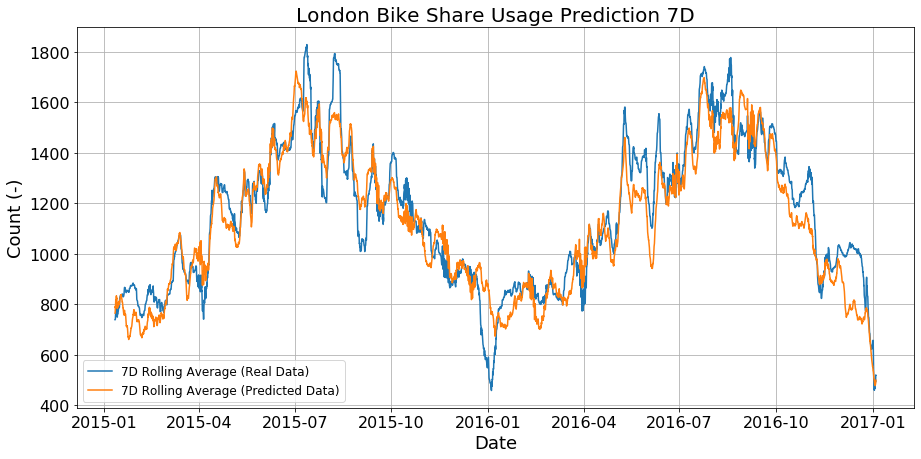

In [68]:
df_plot = df

plt.figure(figsize=(15, 7))

plt.plot(df_plot['timestamp'], df_plot['true_rolling_average_168H'], label = '7D Rolling Average (Real Data)')
plt.plot(df_plot['timestamp'], df_plot['pred_2_rolling_average_168H'], label = '7D Rolling Average (Predicted Data)')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (-)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage Prediction 7D', fontsize=20)

plt.grid()
plt.legend(fontsize=12)
# plt.legend(fontsize=12, loc='upper right')
plt.show()

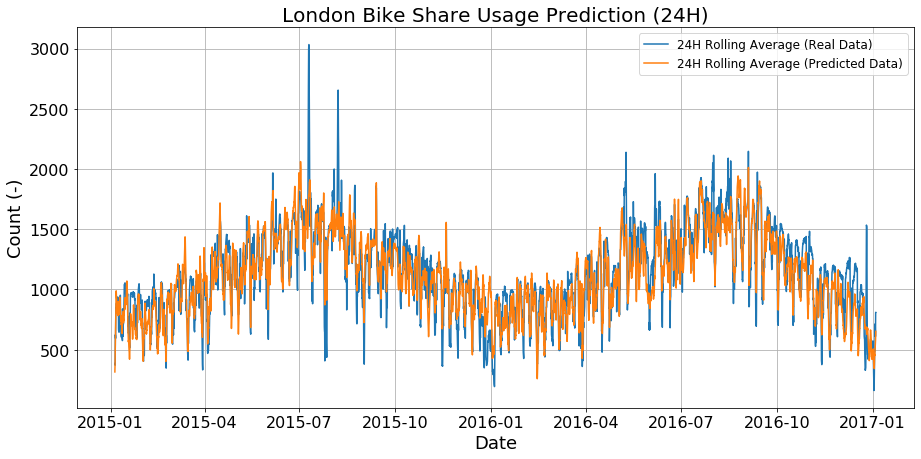

In [69]:
df_plot = df

plt.figure(figsize=(15, 7))

plt.plot(df_plot['timestamp'], df_plot['true_rolling_average_24H'], label = '24H Rolling Average (Real Data)')
plt.plot(df_plot['timestamp'], df_plot['pred_2_rolling_average_24H'], label = '24H Rolling Average (Predicted Data)')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (-)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage Prediction (24H)', fontsize=20)

plt.grid()
plt.legend(fontsize=12)
# plt.legend(fontsize=12, loc='upper right')
plt.show()

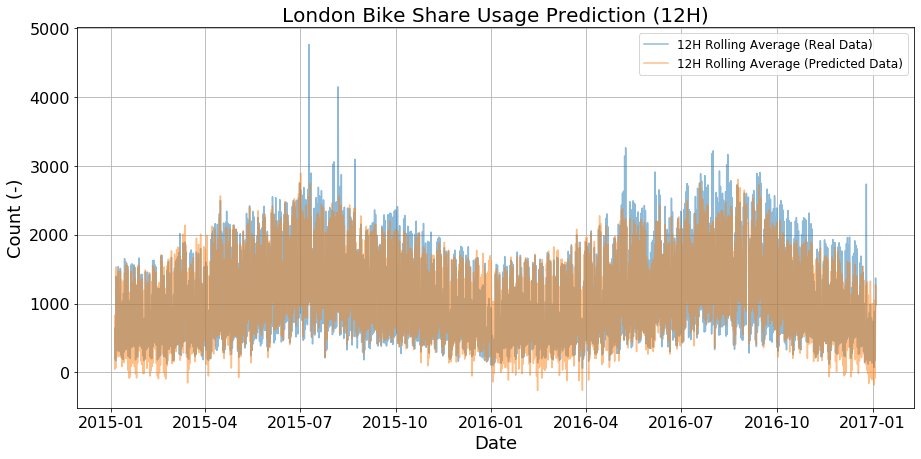

In [70]:
df_plot = df

plt.figure(figsize=(15, 7))

plt.plot(df_plot['timestamp'], df_plot['true_rolling_average_12H'], label = '12H Rolling Average (Real Data)', alpha = 0.5)
plt.plot(df_plot['timestamp'], df_plot['pred_2_rolling_average_12H'], label = '12H Rolling Average (Predicted Data)', alpha = 0.5)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (-)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage Prediction (12H)', fontsize=20)

plt.grid()
plt.legend(fontsize=12)
# plt.legend(fontsize=12, loc='upper right')
plt.show()

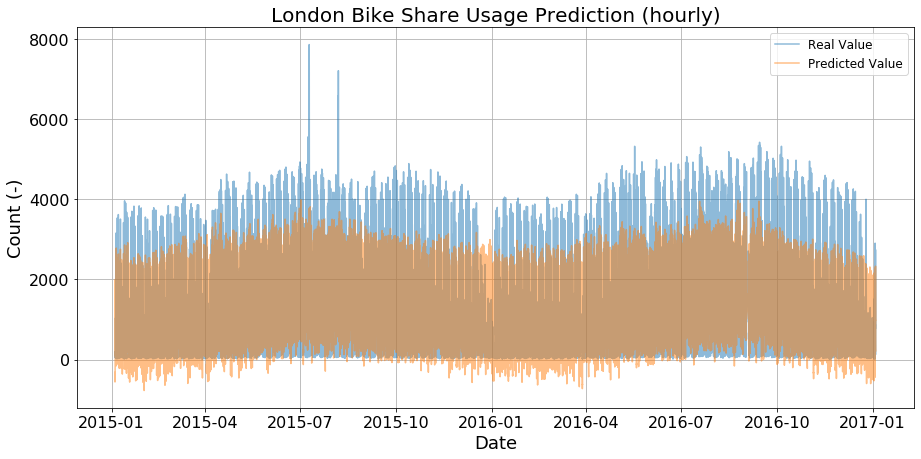

In [71]:
df_plot = df

plt.figure(figsize=(15, 7))

plt.plot(df_plot['timestamp'], df_plot['cnt'], label = 'Real Value', alpha = 0.5)
plt.plot(df_plot['timestamp'], df_plot['y_pred_half_half'], label = 'Predicted Value', alpha = 0.5)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Count (-)', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('London Bike Share Usage Prediction (hourly)', fontsize=20)

plt.grid()
plt.legend(fontsize=12)
# plt.legend(fontsize=12, loc='upper right')
plt.show()

seems that the amplitudes don't fit as well as expected

In [72]:
mean_squared_error(df['cnt'] , df['y_pred_half_half'])

336018.8740256005

In [73]:
df['y_pred_half_half_minimum_0'] = df['y_pred_half_half'].apply(lambda x: 0 if x<0 else x)

In [74]:
mean_squared_error(df['cnt'] , df['y_pred_half_half_minimum_0'])

327199.81604789203

^ slight improvements

In [75]:
"""12H RA comparison"""
mean_squared_error(df[(~df['true_rolling_average_12H'].isnull()) &
                      (~df['pred_2_rolling_average_12H'].isnull())]['true_rolling_average_12H'] , 
                   
                   df[(~df['true_rolling_average_12H'].isnull()) &
                      (~df['pred_2_rolling_average_12H'].isnull())]['pred_2_rolling_average_12H']
                  )

52015.60829783682

In [76]:
"""24H RA comparison"""
mean_squared_error(df[(~df['true_rolling_average_24H'].isnull()) &
                      (~df['pred_2_rolling_average_24H'].isnull())]['true_rolling_average_24H'] , 
                   
                   df[(~df['true_rolling_average_24H'].isnull()) &
                      (~df['pred_2_rolling_average_24H'].isnull())]['pred_2_rolling_average_24H']
                  )

27118.59543113756

## Evaluation

In [77]:
correlation_data = pd.DataFrame(X_train.columns)

In [78]:
correlation_data['coef_'] = linear_model.coef_

In [79]:
correlation_data.sort_values(by = 'coef_', ascending = False)

,0,coef_
21,hour_of_day_8,2540.336179
30,hour_of_day_17,2267.344663
31,hour_of_day_18,2088.276886
29,hour_of_day_16,1294.730796
22,hour_of_day_9,1261.374664
20,hour_of_day_7,1238.053592
32,hour_of_day_19,1157.299373
28,hour_of_day_15,973.109947
26,hour_of_day_13,942.592621
25,hour_of_day_12,902.423628


hour of the day is a very good indicator, shows most people use bikes for work commute

## Contact for Questions/Feedbacks

junyi_429730731@hotmail.co.uk